In [1]:
use_qiskit_for_qnode = False
use_torch_for_optimization = True

In [2]:
import time
import qiskit
import pennylane as qml
if use_torch_for_optimization:
    import torch
    import numpy as np
else:
    import pennylane.numpy as np
import matplotlib.pyplot as plt

In [3]:
def make_target(num_spins, dt=0.03, num_steps=100, h=3.):
    target_circuit = qiskit.QuantumCircuit(num_spins)

    for _ in range(num_steps):
        for iq in range(num_spins):
            target_circuit.cx(iq, (iq + 1) % num_spins)
            target_circuit.u1(2. * dt, (iq + 1) % num_spins)
            target_circuit.cx(iq, (iq + 1) % num_spins)
            target_circuit.rx(2. * dt * h, iq)
            
    return target_circuit

In [4]:
def make_ansatz(num_spins, layers=2):
    ansatz = qiskit.circuit.library.EfficientSU2(num_qubits=num_spins, su2_gates=['rz', 'ry'], entanglement='sca', reps=layers)
    return ansatz, ansatz.ordered_parameters

In [5]:
_statevector_backend = qiskit.Aer.get_backend('statevector_simulator')
_sampler_backend = qiskit.Aer.get_backend('qasm_simulator')
def get_magnetization(circuit, use_statevector=True):
    job = qiskit.execute(circuit, _statevector_backend if use_statevector else _sampler_backend)
    
    if use_statevector:
        statevector = job.result().results[0].data.statevector
        indices = np.arange(statevector.shape[0], dtype=np.uint8) # works for only up to 8 qubits
        indices = np.expand_dims(indices, axis=1)
        m = (np.ones(statevector.shape[0], dtype=np.float) - np.unpackbits(indices, axis=1) * 2) / circuit.num_qubits
        return np.sum(np.square(np.abs(statevector)) * m)
    
    else:
        data = job.result().get_counts(circuit)
        raise NotImplementedError()

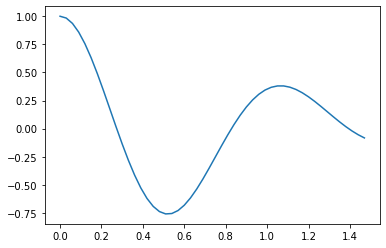

In [6]:
backend = qiskit.Aer.get_backend('statevector_simulator')

num_spins = 6

t = 1.5
sim_length = 50
dt = t / sim_length

magnetization = np.empty(sim_length, dtype=np.float)
#pauli = qiskit.quantum_info.Pauli(z=np.ones(num_spins, dtype=np.bool), x=np.zeros(num_spins, ))

for num_steps in range(sim_length):
    circuit = make_target(num_spins, dt=dt, num_steps=num_steps)
    job = qiskit.execute(circuit, backend)
    statevector = job.result().results[0].data.statevector

    indices = np.arange(statevector.shape[0], dtype=np.uint8) # works for only up to 8 qubits
    indices = np.expand_dims(indices, axis=1)
    m = 1. - np.sum(np.unpackbits(indices, axis=1), axis=1) / num_spins * 2.

    magnetization[num_steps] = np.sum(np.square(np.abs(statevector)) * m)
    
plt.plot(np.arange(0., t, dt), magnetization)

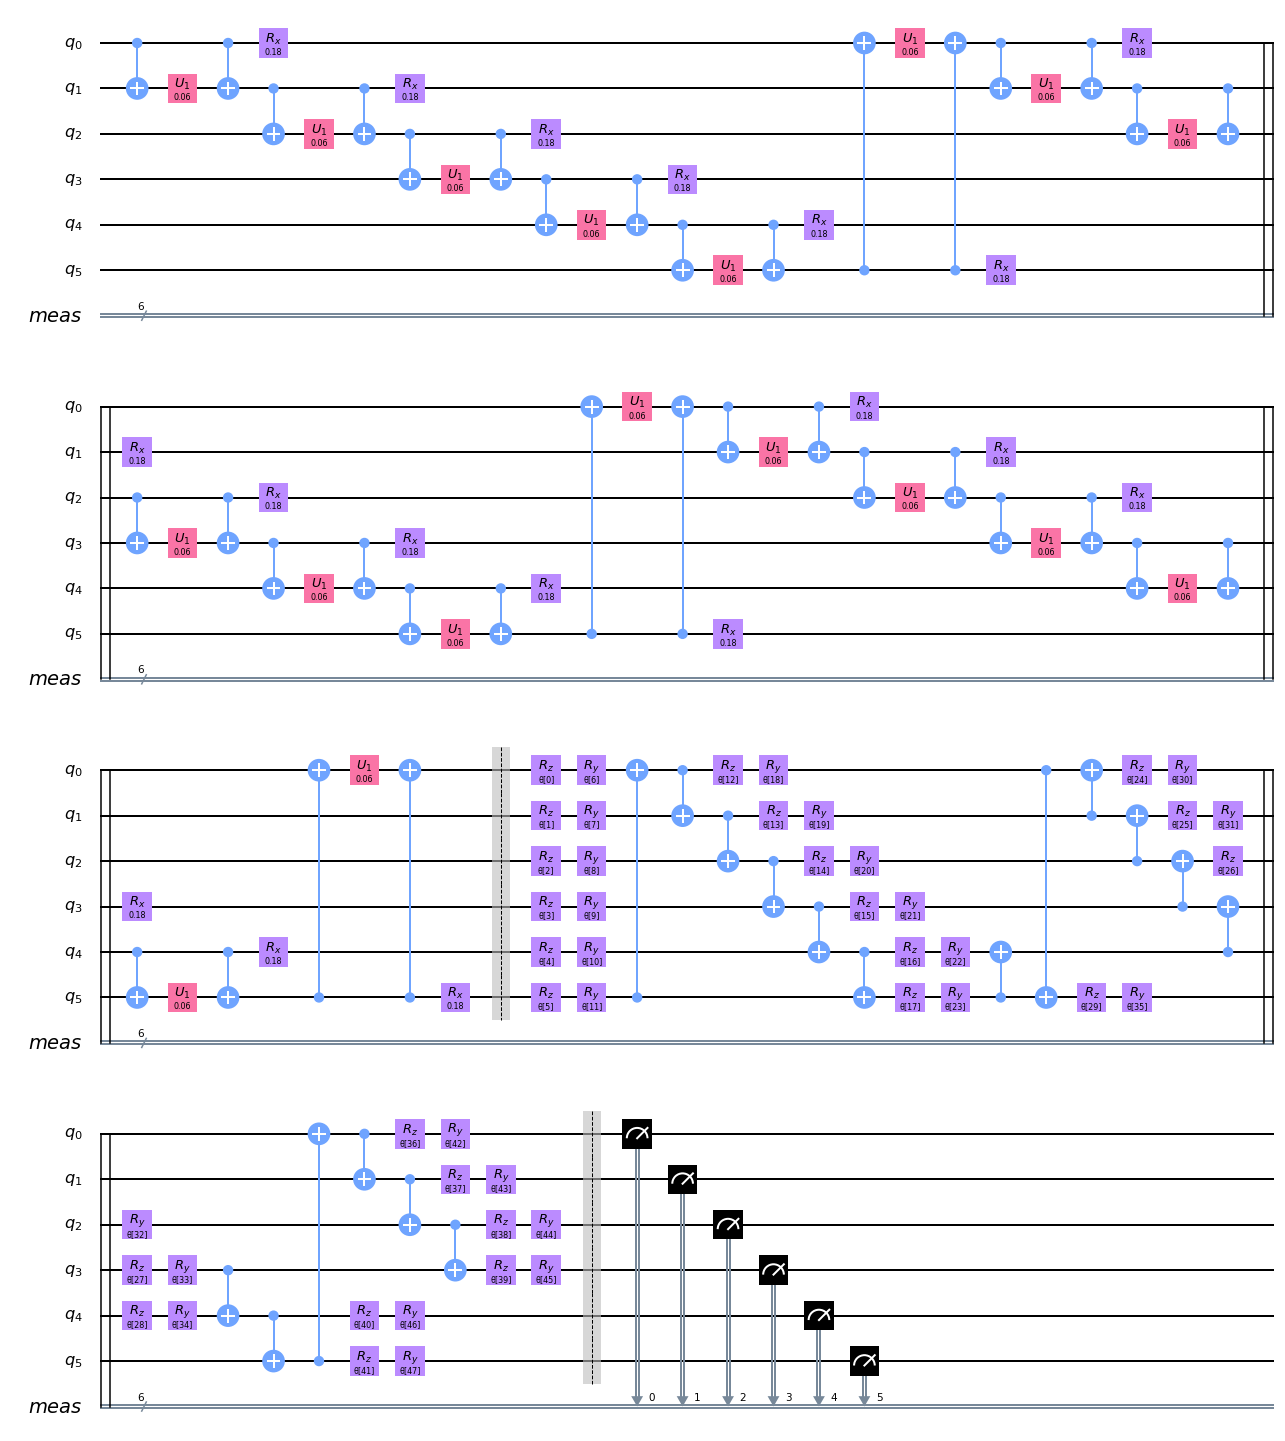

In [7]:
num_spins = 6
num_steps = 3
num_layers = 3

target = make_target(num_spins, num_steps=num_steps)
ansatz, qc_theta = make_ansatz(num_spins, num_layers)

full_circuit = qiskit.QuantumCircuit()
full_circuit += target
full_circuit.barrier()
full_circuit += ansatz
full_circuit.measure_all()
full_circuit.draw('mpl')

In [8]:
dev = qml.device('default.qubit', wires=num_spins)
wires = list(range(num_spins))

if use_qiskit_for_qnode:
    print('Making qnode from qiskit')
    qml_circuit = qml.from_qiskit(target + ansatz)

    #dev = qml.device('qiskit.aer', wires=num_spins, backend='qasm_simulator')

    @qml.qnode(dev, interface='torch')
    def circuit(theta):
        parameter_binding = dict((qc_theta[iq], theta[iq]) for iq in range(len(qc_theta)))

        qml_circuit(parameter_binding, wires=wires)

        return qml.probs(wires=wires)
    
else:
    print('Making pennylane-native qnode')
    
    dt=0.03
    h=3.
    
    @qml.qnode(dev, interface=('torch' if use_torch_for_optimization else 'autograd'))
    def circuit(theta):
        for _ in range(num_steps):
            for iq in range(num_spins):
                qml.CNOT(wires=[iq, (iq + 1) % num_spins])
                qml.RZ(2. * dt, wires=((iq + 1) % num_spins))
                qml.CNOT(wires=[iq, (iq + 1) % num_spins])
                qml.RX(2. * dt * h, wires=iq)
                
        it = 0
        for il in range(num_layers):
            for iq in range(num_spins):
                qml.RZ(theta[it], wires=iq)
                it += 1
            for iq in range(num_spins):
                qml.RY(theta[it], wires=iq)
                it += 1
            for iq in range(num_spins):
                if il % 2 == 0:
                    qml.CNOT(wires=[(iq - il - 1) % num_spins, (iq - il) % num_spins])
                else:
                    qml.CNOT(wires=[(iq - il) % num_spins, (iq - il - 1) % num_spins])

        for iq in range(num_spins):
            qml.RZ(theta[it], wires=iq)
            it += 1
        for iq in range(num_spins):
            qml.RY(theta[it], wires=iq)
            it += 1
            
        return qml.probs(wires=wires)

Making pennylane-native qnode


In [9]:
iterations = 2000
losses = np.empty(iterations, dtype=np.float)
times = np.zeros(iterations, dtype=np.float)

if use_torch_for_optimization:
    print('Using torch to optimize')
    
    #device = torch.device('cuda:0')
    device = torch.device('cpu')
    #device = None

    qml_theta = torch.ones(num_spins * 2 * (num_layers + 1), requires_grad=True, device=device)

    optimizer = torch.optim.Adam([qml_theta], lr=0.1, betas=(0.9, 0.999), eps=1.e-8)

    def cost(theta):
        return -circuit(theta)[0]

    def closure():
        optimizer.zero_grad()
        loss = cost(qml_theta)
        loss.backward()
        return loss

    t0 = time.time()
    for it in range(iterations):
        losses[it] = optimizer.step(closure)
        if it > 100 and np.abs(np.mean(losses[it - 10:it]) - losses[it]) < 1.e-12:
            break

        t1 = time.time()
        times[it] = t1 - t0
        t0 = t1

    theta_optim = optimizer.param_groups[0]['params'][0].detach().numpy()

else:
    print('Using pennylane to optimize')
    
    qml_theta = np.ones(num_spins * 2 * (num_layers + 1), dtype=np.float)
        
    optimizer = qml.AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.999, eps=1.e-8)
    
    def cost(theta):
        return -circuit(theta)[0]
    
    t0 = time.time()
    for it in range(iterations):
        losses[it] = cost(qml_theta)
        if it > 100 and np.abs(np.mean(losses[it - 10:it]) - losses[it]) < 1.e-12:
            break
            
        qml_theta = optimizer.step(cost, qml_theta)
        t1 = time.time()
        times[it] = t1 - t0
        t0 = t1
    
    theta_optim = qml_theta
    
print(theta_optim)
print(cost(theta_optim))
print(np.mean(times))

Using torch to optimize
[ 1.2494187e-01  1.4527626e+00  1.4527707e+00 -1.4044285e+00
  1.4524932e+00  3.1432557e-01  1.5766692e+00  1.0334834e+00
  1.0357754e+00  5.0584537e-01  1.0327599e+00  1.3197811e+00
  1.6006246e+00 -2.1334219e-04  9.5725536e-01  1.2128328e+00
  1.5708044e+00  1.4661220e-05  1.2322707e+00  1.5705664e+00
 -8.2259595e-02  1.4829473e+00  1.5927765e+00  1.5707620e+00
  1.2248956e+00  2.1757789e+00  1.5836158e+00 -8.2933595e-03
  1.5712321e+00  1.9336617e+00  3.4728828e-01  1.5709548e+00
 -1.8040443e-04  1.5707947e+00  1.5707932e+00  6.3617069e-01
  2.1418760e+00  1.5709047e+00  1.5707926e+00  1.3084426e+00
  2.3150928e+00  1.5927349e+00 -1.5575368e-03  1.5708305e+00
  1.5707924e+00 -1.8681830e-02  4.5737084e-05  1.5799915e+00]
tensor(-0.9999, dtype=torch.float64)
0.6592409420013428


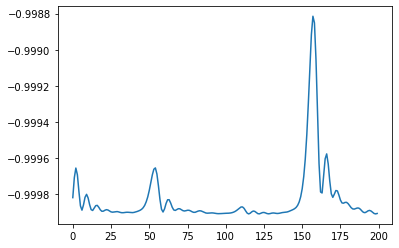

In [12]:
#plt.plot(np.arange(iterations), losses)
plt.plot(np.arange(200), losses[-200:])

In [13]:
backend_sim = qiskit.Aer.get_backend('qasm_simulator')

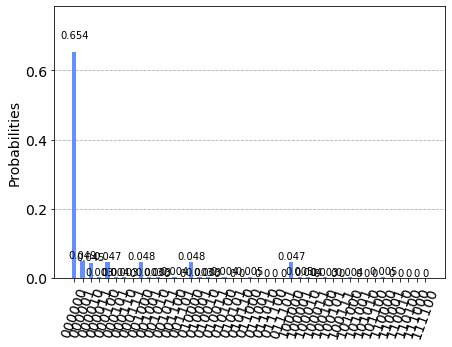

In [14]:
target_circuit = target.measure_all(inplace=False)
job = qiskit.execute(target_circuit, backend_sim, shots=8129)
result = job.result()
qiskit.visualization.plot_histogram(result.get_counts(target_circuit))

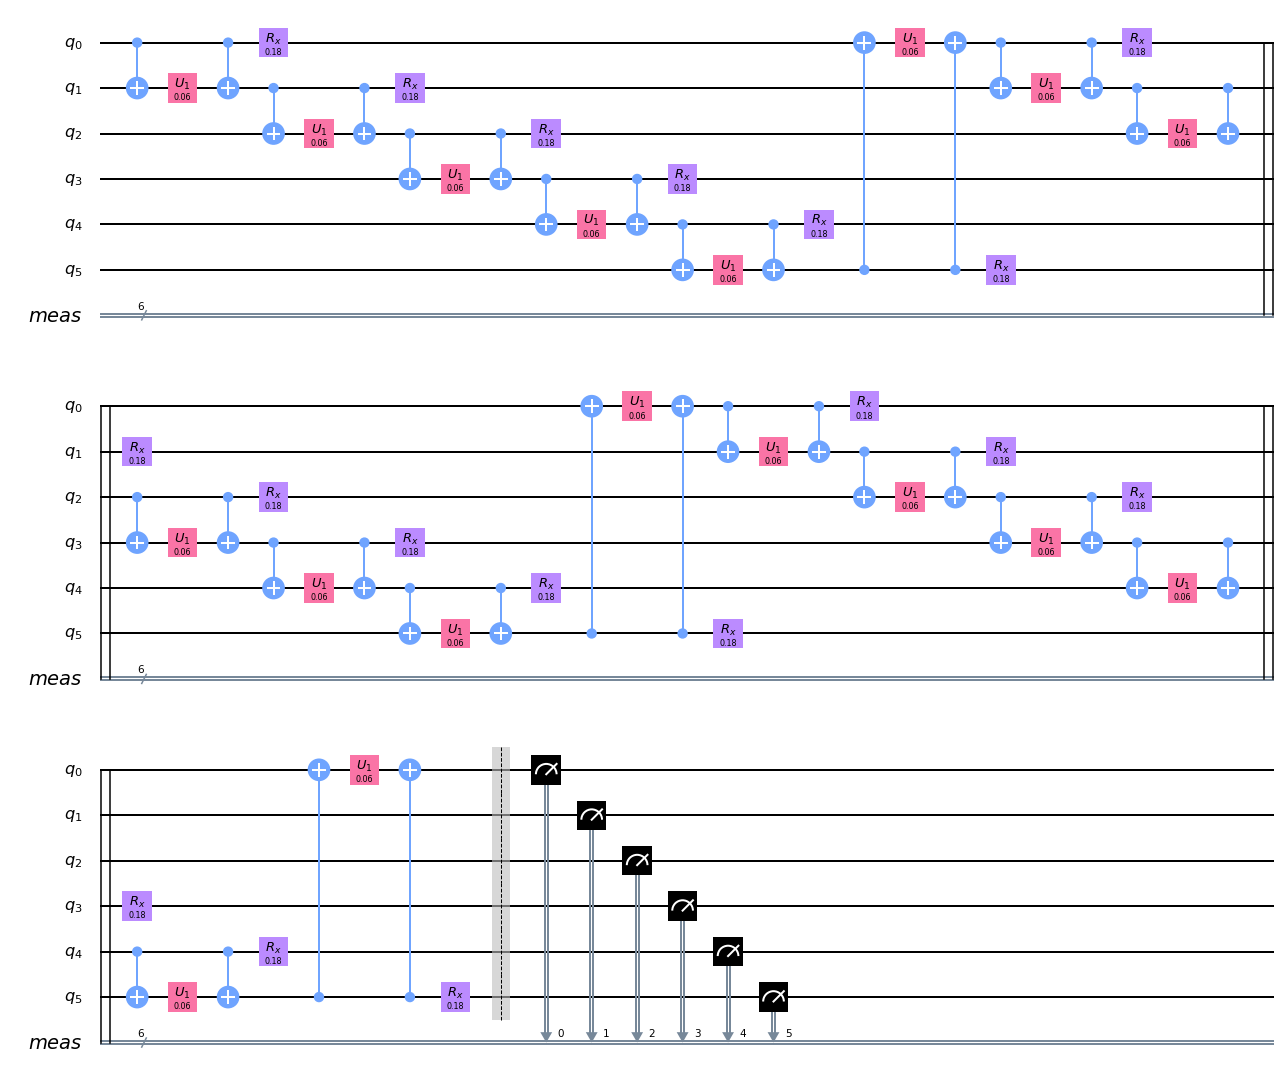

In [15]:
target_circuit.draw('mpl')

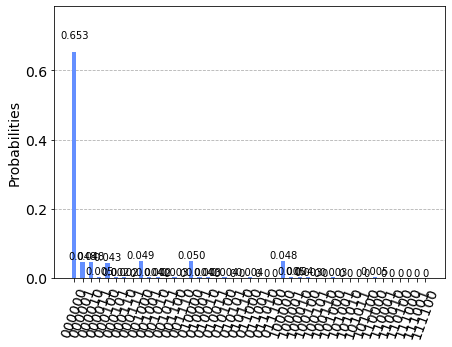

In [16]:
ansatz, qc_theta = make_ansatz(num_spins, num_layers)
param_binding = dict((qc_theta[iq], theta_optim[iq].item()) for iq in range(len(qc_theta)))
approx_circuit = ansatz.bind_parameters(param_binding).inverse()
approx_circuit.measure_all()
job = qiskit.execute(approx_circuit, backend_sim, shots=8129)
result = job.result()
qiskit.visualization.plot_histogram(result.get_counts(approx_circuit))

In [17]:
print(target_circuit.depth(), approx_circuit.depth())

56 27


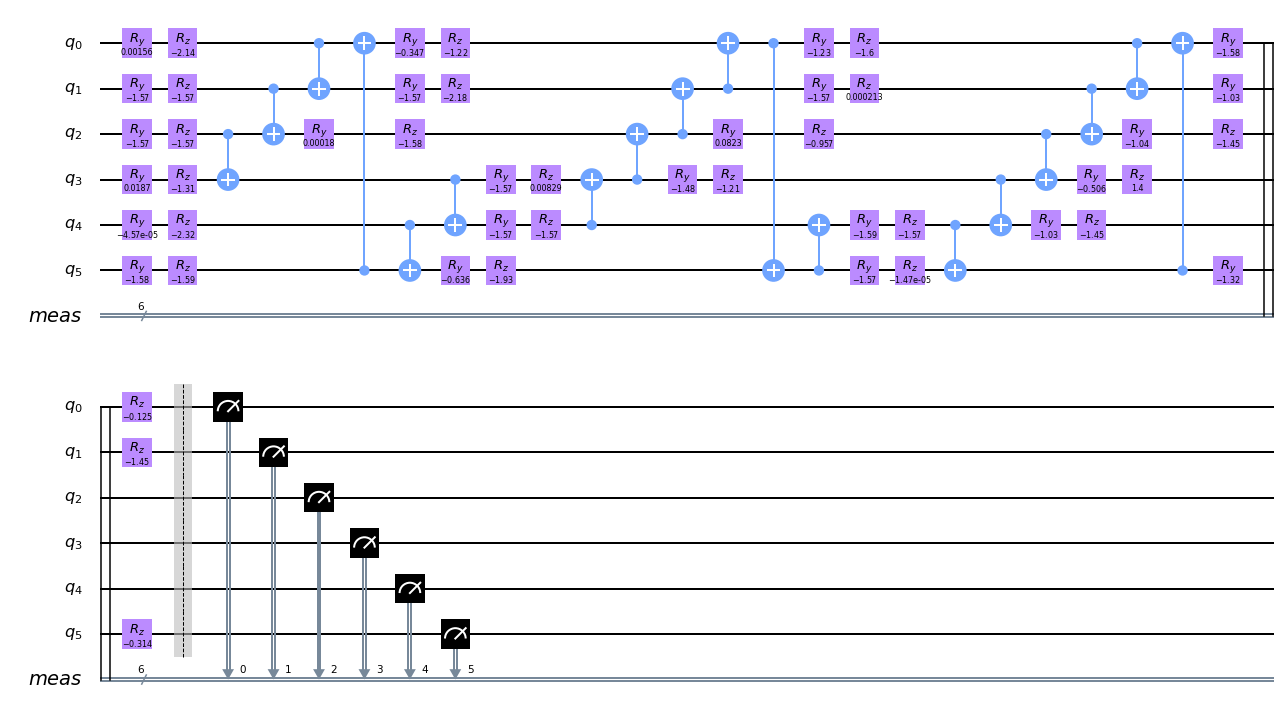

In [18]:
approx_circuit.draw('mpl')

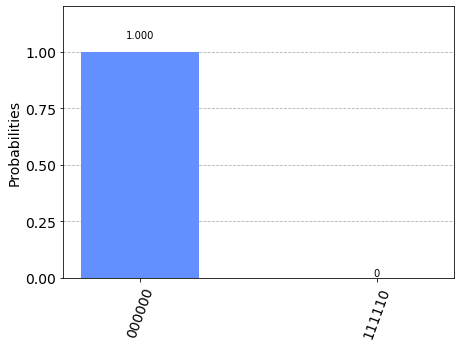

In [19]:
full_circuit = (target + ansatz.bind_parameters(param_binding)).measure_all(inplace=False)
job = qiskit.execute(full_circuit, backend_sim, shots=8129)
result = job.result()
qiskit.visualization.plot_histogram(result.get_counts(full_circuit))

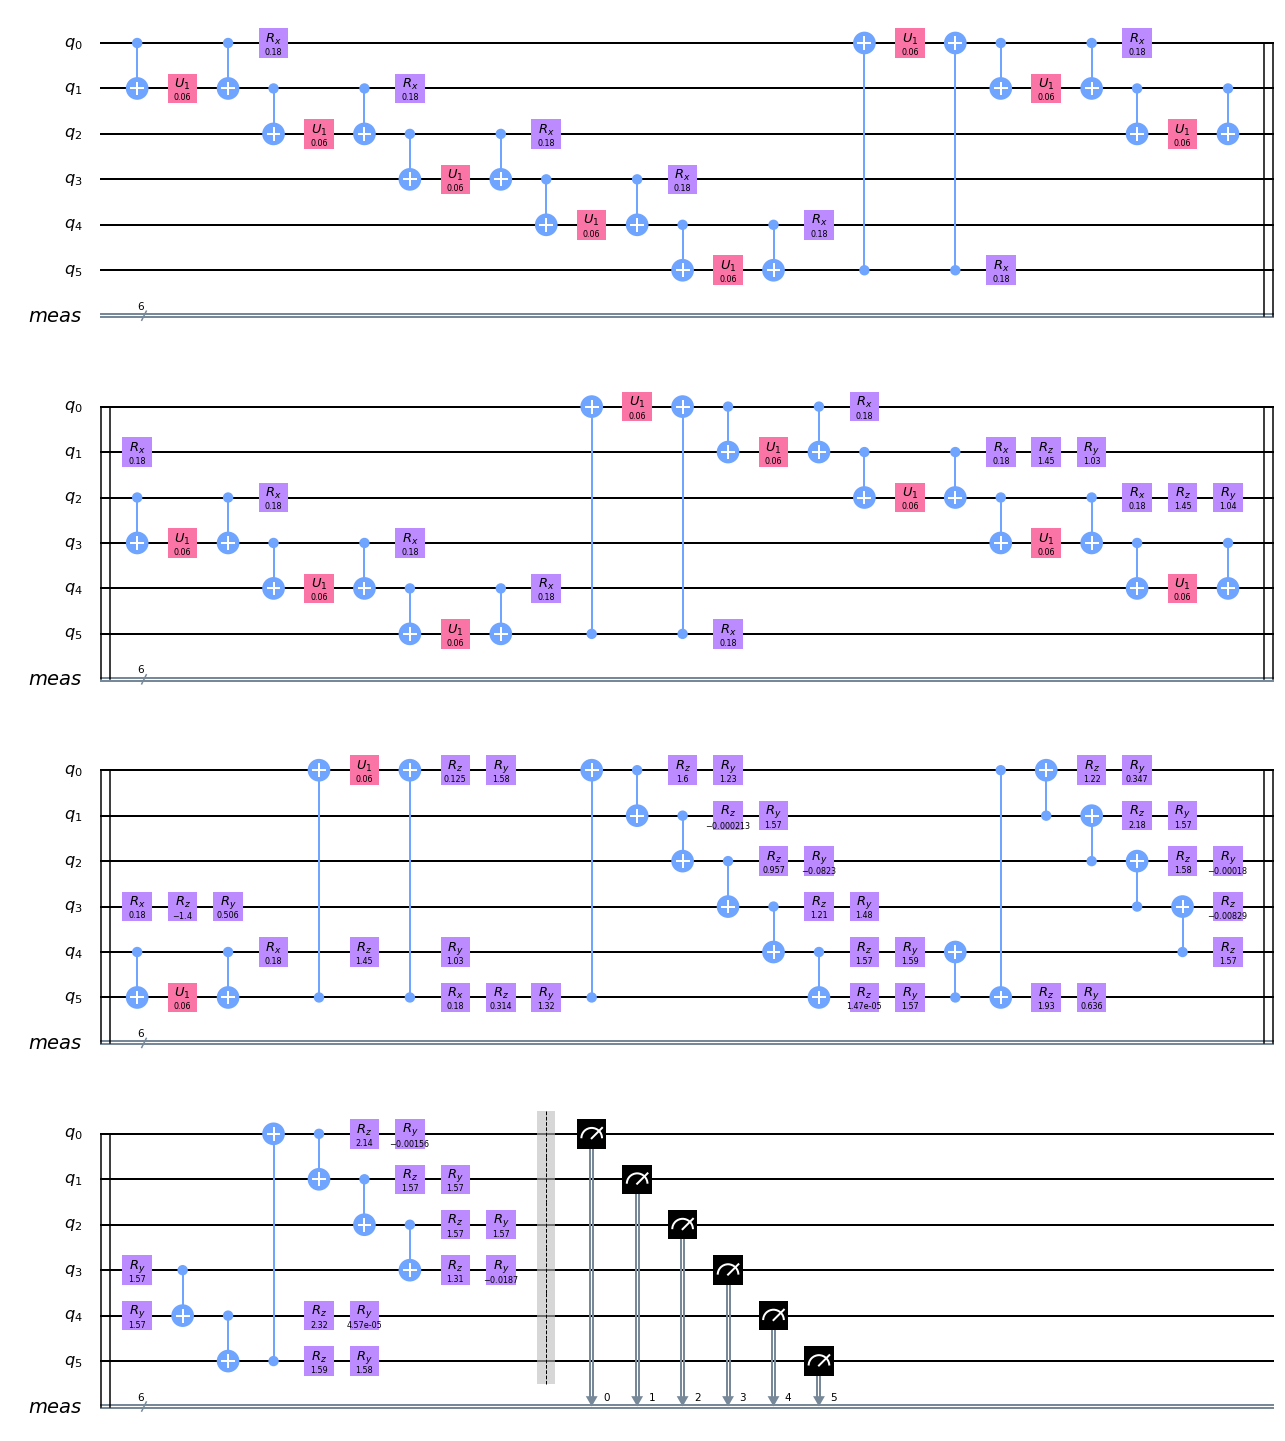

In [20]:
full_circuit.draw('mpl')